In [1]:
import pandas as pd

data=pd.read_csv('data/baron/BaronMatrix.csv',index_col=0)
annotation=pd.read_csv('data/baron/BaronMetaData.csv',index_col=0)

annotation["celltype"]=annotation["cell.type"]

base_dir="data/baron"

In [2]:
data_sparse=data


#statistics of cells expressing each gene
gene_expressed_cell_number=data_sparse.astype(bool).sum(axis=0)

print(len(gene_expressed_cell_number))
#filter gene expressed in less than 10 cells
gene_expressed_cell_number=gene_expressed_cell_number[gene_expressed_cell_number>2000]
print(len(gene_expressed_cell_number))

data_rm_sparse=data_sparse[gene_expressed_cell_number.index.tolist()]
data_rm_sparse.shape           #10k cells, 4487 genes



import pickle
TF_gene_dict=pickle.load(open("human/TF_gene_dict","rb"))

len(TF_gene_dict)



#generate gene_to_TF_transform_matrix
import numpy as np
import pickle

TF_gene_dict=pickle.load(open("human/TF_gene_dict","rb"))


gene_number=len(data_rm_sparse.columns.to_list())    

TF_number=len(TF_gene_dict)

gene_to_TF_transform_matrix=np.zeros((gene_number,TF_number))

TF_list=TF_gene_dict.keys()
for i,gene in enumerate(data_rm_sparse.columns):
    try:
        j=TF_list.index("gene")
        gene_to_TF_transform_matrix[i][j]=1
    except:
        pass
        
gene_to_TF_transform_matrix

pickle.dump(gene_to_TF_transform_matrix,open("%s/gene_to_TF_transform_matrix" %base_dir,"wb"))



#generate TF_mask

import numpy as np

gene_TF_dict=pickle.load(open("human/gene_TF_dict","rb"))

gene_number = len(data_rm_sparse.columns.to_list())    #6033
TF_number = len(TF_gene_dict)

TF_mask = np.zeros((gene_number,TF_number))
error_count=0

for i,gene_id in enumerate(data_rm_sparse.columns):

    for j,TF in enumerate(TF_gene_dict):
        if TF in gene_TF_dict.get(gene_id,[]):
            TF_mask[i][j]=1
        else:
            error_count+=1
        
print(error_count)
print(TF_mask)

pickle.dump(TF_mask,open("%s/TF_mask" %base_dir,"wb"))



#generate GO_mask

GO_dict={}
with open("human/goa_human.gaf") as f:
    for line in f:
        if line[0] == "!":
            continue
        
        gene_id=line.split("\t")[2]
        GO_term=line.split("\t")[4]
        if GO_term not in GO_dict:
            GO_dict[GO_term]=[]
        GO_dict[GO_term].append(gene_id)


GO_list=[]
count=0
for item in GO_dict:
    if len(GO_dict[item])>=40:
        count+=1
        GO_list.append(item)
print(count)


gene_dict={}
with open("human/goa_human.gaf") as f:
    for line in f:
        if line[0]=="!":
            continue
        gene_id=line.split("\t")[2].upper()
        GO_term=line.split("\t")[4]
        if gene_id not in gene_dict:
            gene_dict[gene_id]=[]
        gene_dict[gene_id].append(GO_term)



gene_number=len(gene_expressed_cell_number.index.tolist())    #6033
GO_number=len(GO_list)  

GO_mask=np.zeros((gene_number,GO_number))
error_count=0

for i,gene_id in enumerate(data_rm_sparse.columns):

    for j,GO_term in enumerate(GO_list):
        if GO_term in gene_dict.get(gene_id,"GO:default"):

            GO_mask[i][j]=1
        else:
            error_count+=1
        
print(error_count)

pickle.dump(GO_mask,open("%s/GO_mask" %base_dir,"wb"))


#generate GO_TF_mask

TF_number=len(TF_gene_dict)
GO_number=len(GO_list) 

GO_TF_mask=np.zeros((TF_number,GO_number))
error_count=0

for i,TF in enumerate(TF_gene_dict):
    for j,GO in enumerate(GO_list):
        if GO in gene_dict.get(TF,"GO:default"):
            GO_TF_mask[i][j]=1
        else:
            error_count+=1
print(error_count)
        
GO_TF_mask

pickle.dump(GO_TF_mask,open("%s/GO_TF_mask" %base_dir,"wb"))


20125
2443
1888604
[[1. 1. 1. ... 0. 0. 0.]
 [1. 0. 1. ... 0. 0. 0.]
 [1. 1. 1. ... 0. 0. 0.]
 ...
 [0. 1. 0. ... 0. 0. 0.]
 [1. 1. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]]
1411
3414730
1686601


In [3]:
def calculate_multiclass_f1_score(true_labels, predicted_labels):
    if len(true_labels) != len(predicted_labels):
        raise ValueError("Input lists must have the same length.")

    unique_labels = set(true_labels + predicted_labels)
    f1_scores = []

    for label in unique_labels:
        true_positive = sum(1 for true, pred in zip(true_labels, predicted_labels) if true == label and pred == label)
        false_positive = sum(1 for true, pred in zip(true_labels, predicted_labels) if true != label and pred == label)
        false_negative = sum(1 for true, pred in zip(true_labels, predicted_labels) if true == label and pred != label)

        precision = true_positive / (true_positive + false_positive) if true_positive + false_positive > 0 else 0
        recall = true_positive / (true_positive + false_negative) if true_positive + false_negative > 0 else 0

        f1 = 2 * (precision * recall) / (precision + recall) if precision + recall > 0 else 0
        f1_scores.append(f1)

    macro_f1 = sum(f1_scores) / len(f1_scores)
    return macro_f1

In [4]:
#GO_Net
import math
import numpy as np
import pandas as pd
import pickle
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable
from sklearn.model_selection import train_test_split as ts

data_rm_sparse=data_rm_sparse

data_rm_sparse.index=annotation["celltype"].to_list()

###############################################################
gene_to_TF_transform_matrix=pickle.load(open("%s/gene_to_TF_transform_matrix" %base_dir,"rb"))
TF_mask=pickle.load(open("%s/TF_mask" %base_dir,"rb"))
GO_mask=pickle.load(open("%s/GO_mask" %base_dir,"rb"))
GO_TF_mask=pickle.load(open("%s/GO_TF_mask" %base_dir,"rb")) 
###############################################################
#data_annotation = pd.read_csv('data/macparland/GSE115469_CellClusterType.txt', sep="\t")
#index_rename_dict = {key: value for key, value in zip(data_annotation['CellName'], data_annotation['CellType'])}
#$data_rm_sparse=data_rm_sparse.rename(index=index_rename_dict)

#normalize by row
#data_rm_sparse = data_rm_sparse.apply(lambda row: row / np.linalg.norm(row), axis=1)

#merge similar cell types
#data_rm_sparse.index = data_rm_sparse.index.str.replace('Hepatocyte_\d+', 'Hepatocyte', regex=True)
#data_rm_sparse.index = data_rm_sparse.index.str.replace('gamma-delta_T_Cells_\d+', 'gamma-delta_T_Cells', regex=True)


#filter low count cells
#data_rm_sparse = data_rm_sparse[data_rm_sparse.index != 'Hepatic_Stellate_Cells']


#novel_cell_type = ['Plasma_Cells']

#data_rm_sparse_novel = data_rm_sparse[data_rm_sparse.index.isin(novel_cell_type)]
#data_rm_sparse_rest = data_rm_sparse[~data_rm_sparse.index.isin(novel_cell_type)]




classes=[]
for celltype in data_rm_sparse.index:
    if celltype not in classes:
        classes.append(celltype)
#print(len(classes),classes)


label_dict_revese={}
label_dict={}
for i,celltype in enumerate(classes):
    label_dict[celltype]=i
    label_dict_revese[i]=celltype
label_dict
################################################################



def gen_mask(row,col,percent=0.5,num_zeros=None):
    if num_zeros is None:
        #Total number being masked is 0.5 by default
        num_zeros=int((row*col)*percent)
    
    mask=np.hstack([np.zeros(num_zeros),np.ones(row*col-num_zeros)])
    np.random.shuffle(mask)
    return mask.reshape(row,col)

class LinearFunction(torch.autograd.Function):
    """
    autograd function which masks it's weights by 'mask'.
    """
    
    #Not that both forward and backword are @staticmethod

    
    #bias, mask is an optional argument
    @staticmethod
    def forward(ctx, input, weight, bias=None, mask=None):
        if mask is not None:
            #change weight to 0 where mask == 0

            weight=weight*mask
 
        output=input.mm(weight.t())

        if bias is not None:
            output+=bias.unsqueeze(0).expand_as(output)
        
        ctx.save_for_backward(input, weight, bias, mask)

        return output
    
    #This function has noly a single output, so it gets only one gradient
    @staticmethod
    def backward(ctx,grad_output):
        input,weight,bias,mask = ctx.saved_tensors
        grad_input=grad_weight=grad_bias=grad_mask=None
        
        #These meeds_input_grad checks are optional and there only to improve efficiency.
        #If you want to make your code simpler, you can skip them. Returning gradients for
        #inputs that don't require it is not an error.
        if ctx.needs_input_grad[0]:
            grad_input=grad_output.mm(weight)
        
        if ctx.needs_input_grad[1]:
            grad_weight=grad_output.t().mm(input)
            
            if mask is not None:
                
                #change grad_weight to 0 where mask == 0
                grad_weight=grad_weight*mask

        
        #if bias is not None and ctx.need_input_grad[2]:
        if ctx.needs_input_grad[2]:
            grad_bias=grad_output.sum(0).squeeze(0)
        
        return grad_input,grad_weight,grad_bias,grad_mask
    

       
class CustomizedLinear(nn.Module):
    def __init__(self,input_features,output_features, bias=None, mask=None):
        """
        Arguments
        mask [numpy array]:
            The shape is (n_input_fearues,n_output_features).
            The elements are 0 or 1 which delcare un-connected or connected.
            
        bias [bool]:
            flg of bias.
        """
        super(CustomizedLinear,self).__init__()
        self.input_features=input_features
        self.out_features=output_features
        
        #nn.Parameter is a spetial kind of Tensor, that will get
        #automatically registered as Module's parameter once it's assigned
        #as an attribute
        self.weight=nn.Parameter(torch.Tensor(self.out_features,self.input_features))
        
        if bias:

            self.bias=nn.Parameter(torch.Tensor(self.out_features))
        else:
            #You should always register all possible parameters, but the
            #optinal ones can be None if you want.
            self.register_parameter("bias",None)
            
        #Initialize the above parameters (weight and bias). Important!
        self.init_params()
        
        #mask should be registered after weight and bias
        if mask is not None:
            mask=torch.tensor(mask,dtype=torch.float).t()
            self.mask=nn.Parameter(mask,requires_grad=False)
        else:
            self.register_parameter("mask",None)

        
    def init_params(self):
        stdv=1./math.sqrt(self.weight.size(1))
        self.weight.data.uniform_(-stdv,stdv)
        if self.bias is not None:
            self.bias.data.uniform_(-stdv,stdv)
                
    def forward(self,input):
        #See the autograd section for explanation of what happens here.
        
        output=LinearFunction.apply(input,self.weight,self.bias,self.mask)
        
        return output
        
    def extra_repr(self):
        #(Optional) Set the extra informatioin about this module. You can test
        #it by printing an object of this class.
        return "input_features={}, output_features={}, bias={}, mask={}".format(
            self.input_features, self.out_features,
            self.bias is not None, self.mask is not None)
        
        
class GO_Net(nn.Module):
    def __init__(self,in_size,out_size,ratio=[0.006525,0,0]):
        super(GO_Net,self).__init__()

        self.gene_number=len(gene_expressed_cell_number.index.tolist())    #6033
        self.TF_number=1209
        self.GO_number=len(GO_list)
        self.class_number=3

        self.gene_to_TF_transform_matrix=torch.tensor(gene_to_TF_transform_matrix,dtype=torch.float32)
    
        
        self.bn0=nn.BatchNorm1d(self.gene_number)
        #self.fc1=CustomizedLinear(in_size,2290,mask=gen_mask(3443,2290,ratio[0]))  
        #self.fc1=CustomizedLinear(in_size,1946,mask=gen_mask(2903,1946,ratio[0]))        
        self.fc1=CustomizedLinear(in_size,self.GO_number,mask=GO_mask)    #GO_term
        self.gene_to_GO_layer=CustomizedLinear(in_size,self.GO_number,mask=GO_mask)    #GO_term
        #self.fc1=CustomizedLinear(in_size,2290,mask=np.ones((3443,2290)))
    
        self.bn1=nn.BatchNorm1d(self.GO_number)
                
        self.fc2=CustomizedLinear(self.GO_number,out_size,mask=gen_mask(self.GO_number,out_size,ratio[1]))
        self.bn2=nn.BatchNorm1d(out_size)

        self.gene_to_TF_layer=CustomizedLinear(self.gene_number,self.TF_number,mask=TF_mask)
        self.TF_to_GO_layer=CustomizedLinear(self.TF_number,self.GO_number,mask=GO_TF_mask)
        
        self.fc3=CustomizedLinear(100,100,mask=gen_mask(100,100,ratio[1]))

        self.fc4=CustomizedLinear(100,out_size,mask=gen_mask(100,out_size,ratio[1]))
        
        self.relu=nn.ReLU()
        self.leaky_relu=nn.LeakyReLU()
        #self.dropout = nn.Dropout(0.1)
        for module in self.modules():
            if isinstance(module,nn.Linear):
                nn.init.uniform_(module.weight,a=0,b=1)
            elif isinstance(module,(nn.BatchNorm1d,nn.GroupNorm)):
                nn.init.constant_(module.weight,1)
                nn.init.constant_(module.bias,0)

                        
    def forward(self,x):

        #x=self.bn0(x)
        TF_residul=torch.matmul(x,self.gene_to_TF_transform_matrix)

        TF_derived_from_gene=self.gene_to_TF_layer(x)

        TF_sum=TF_residul+TF_derived_from_gene
        #TF_sum=TF_derived_from_gene

        GO_derived_from_TF=self.TF_to_GO_layer(TF_sum)

        GO_derived_from_gene=self.gene_to_GO_layer(x)

        GO_sum=GO_derived_from_TF+GO_derived_from_gene

        #x=self.bn0(x)
        #x=self.fc1(x)
        #x=self.bn1(x)
        #x=self.relu(x)
        #x=self.dropout(x)
        GO_sum=self.leaky_relu(GO_sum)

        #x=torch.tanh(x) 
        #print(161,self.fc1.weight)
        x=self.fc2(GO_sum)
        #x=self.bn2(x)
        #x=self.relu(x)
        #x=self.leaky_relu(x)
        #x=self.fc3(x)
        #x=self.leaky_relu(x)
        #x=self.fc4(x)
        return x
        return x,GO_sum,TF_derived_from_gene,GO_derived_from_TF

"""
class Reconstraction(nn.Module):
    def __init__(self,in_size,out_size):
        super(Reconstraction,self).__init__()

        self.decoder = nn.Sequential(
            nn.Linear(in_size, 500),
            nn.LeakyReLU(True),
            nn.Linear(500, 500),
            nn.LeakyReLU(True),
            nn.Linear(500, 500),
            nn.LeakyReLU(True),
            nn.Linear(500, 1000),
            nn.LeakyReLU(True),
            nn.Linear(1000, out_size)
        )

    def forward(self, x):
        x = self.decoder(x)
        return x
"""     


 
class MyDataset(Dataset):
    def __init__(self, x,y):
        self.x=x
        self.y=y

    def __getitem__(self, index):
        features = self.x[index]
        label = self.y[index]
        return features, label

    def __len__(self):
        return len(self.x)

def accuracy_score(y_test,y_pred):
    t=0
    f=0
    for i in range(len(y_test)):
        if y_test[i]==y_pred[i]:
            t+=1
        else:
            f+=1
    return(t/(t+f))



from torch.utils.data import WeightedRandomSampler

def make_weights_for_balanced_classes(dataset, nclasses):
    count = [0] * nclasses
    for item in dataset:
        count[item[1]] += 1
    weight_per_class = [0.] * nclasses
    N = float(sum(count))
    for i in range(nclasses):
        weight_per_class[i] = N/float(count[i])
    weight = [0] * len(dataset)
    for idx, val in enumerate(dataset):
        weight[idx] = weight_per_class[val[1]]
    return weight


class CustomWeightedRandomSampler(WeightedRandomSampler):
    """WeightedRandomSampler except allows for more than 2^24 samples to be sampled"""
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

    def __iter__(self):
        rand_tensor = np.random.choice(range(0, len(self.weights)),
                                       size=self.num_samples,
                                       p=self.weights.numpy() / torch.sum(self.weights).numpy(),
                                       replace=self.replacement)
        rand_tensor = torch.from_numpy(rand_tensor)
        return iter(rand_tensor.tolist())





#training
input_size = len(data_rm_sparse.columns)
output_size = len(classes)

learning_rate = 0.1
epochs = 3


#reconstraction_optimizer = optim.Adam(reconstraction_model.parameters(), lr=0.001)

criterion = nn.CrossEntropyLoss()
#reconstraction_criterion = nn.MSELoss()

#norm data_rm_sparse by col


data_train_x=data_rm_sparse
data_train_y=data_rm_sparse.index



#5-fold cross validation
import numpy as np
from sklearn.model_selection import KFold

num_folds = 5

# Generate 5-fold cross-validation indices
kf = KFold(n_splits=num_folds, shuffle=False)
fold_indices = list(kf.split(data))

# Perform 5-fold cross-validation
for fold, (train_indices, test_indices) in enumerate(fold_indices, start=1):

    #define model and optimizer
    model = GO_Net(input_size, output_size,ratio=[0,0,0])
    optimizer = optim.Adam(model.parameters(), lr=0.001)


    # Subset data and annotation based on indices
    x_train = data_train_x.iloc[train_indices].to_numpy()
    y_train = data_train_y[train_indices,]
    
    x_test = data_train_x.iloc[test_indices].to_numpy()
    y_test = data_train_y[test_indices,]

    # Continue with your operations on data_train, anno_train, data_test, and anno_test




    #x_train,x_test,y_train,y_test = ts(data_train_x.to_numpy(),data_train_y.to_numpy(),test_size=0.2,random_state=1, shuffle=True)

    #x_train=x_train[0:400]
    #y_train=y_train[0:400]

    #label_dict={25:0,26:1,27:2,33:3,34:4}
    y_train_relabeled=[label_dict[label] for label in y_train]
    y_test_relabeled=[label_dict[label] for label in y_test]


    #train_size=20000

    #x_train=x_train[0:train_size]
    #y_train_relabeled=y_train_relabeled[0:train_size]

    train_data=MyDataset(x_train,y_train_relabeled)



    #for unbalanced data
    """
    weights=make_weights_for_balanced_classes(train_data,len(classes))
    weights = torch.DoubleTensor(weights)
    sampler = CustomWeightedRandomSampler(weights, len(weights))        #sampler for imbalanced classes
    """

    #train_loader=DataLoader(train_data, batch_size=60, sampler=sampler)
    train_loader=DataLoader(train_data, batch_size=60, shuffle=True)

    num_epochs=4
    # 训练模型
    for epoch in range(num_epochs):
        running_loss = 0.0
        reconstraction_running_loss = 0.0

        for i, batch in enumerate(train_loader, 0):
            inputs, labels = batch
            #print(labels)
            inputs=Variable(inputs).to(torch.float32)
            labels=Variable(labels).to(torch.long)
            # 将梯度缓存清零
            optimizer.zero_grad()

            # 前向传播、计算损失和反向传播
            #outputs,_,_,_ = model(inputs)
            outputs = model(inputs)

            loss = criterion(outputs, labels)

            #reconstraction_input=reconstraction_model(outputs)
            #reconstraction_loss = reconstraction_criterion(reconstraction_input, inputs)

            #reconstraction_optimizer.zero_grad()

            #combined_loss=loss+reconstraction_loss
            #combined_loss.backward()
            loss.backward()
        
            optimizer.step()
            #reconstraction_optimizer.step()


            #reconstraction_running_loss += reconstraction_loss.item()
            running_loss += loss.item()

            if i % 40 == 0:
                pass
                #print(i)
                #print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 200))
            
            if i>400:
                break

        test_data=MyDataset(x_test,y_test_relabeled)
        test_loader=DataLoader(test_data, batch_size=32, shuffle=False)
        result=[]
        for i, batch in enumerate(test_loader):
            inputs, labels = batch
            
            inputs=Variable(inputs).to(torch.float32)

            labels=Variable(labels).to(torch.long)
            
            #outputs,_,_,_ = model(inputs)
            outputs = model(inputs)
            pred = list(torch.max(outputs, 1)[1].numpy())
            result.extend(pred)
            #print(pred,labels)
            if i>100:
                break
        accuracy = accuracy_score(y_test_relabeled[0:len(result)],result)
        f1_score = calculate_multiclass_f1_score(y_test_relabeled[0:len(result)],result)
                #########
        print("fold %s-%s" %(fold,epoch),"\taccuracy:\t",accuracy,"\tloss:\t",running_loss / len(train_loader)," \tf1 score:\t",f1_score )
        
        #save model
        #pickle.dump(model,open("model/GO_heart.model","wb"))
    break
        


fold 1-0 	accuracy:	 0.9725787631271878 	loss:	 0.3129153620451689  	f1 score:	 0.7960947037435865
fold 1-1 	accuracy:	 0.9731621936989499 	loss:	 0.08435329082017036  	f1 score:	 0.8262303353744006
fold 1-2 	accuracy:	 0.9754959159859977 	loss:	 0.04406913432758301  	f1 score:	 0.9274595971307699
fold 1-3 	accuracy:	 0.9766627771295215 	loss:	 0.020855839742327353  	f1 score:	 0.9511773597335148


In [5]:
test_data=MyDataset(x_test,y_test_relabeled)
test_loader=DataLoader(test_data, batch_size=2000, shuffle=False)

for i, batch in enumerate(test_loader):
    input, labels = batch
    
    input=Variable(input).to(torch.float32)
    break


for i,celltype in enumerate(classes):
    print(i,celltype,data_rm_sparse.index.to_list().count(celltype))

0 Acinar cells 958
1 Beta cells 2525
2 Delta cells 601
3 Pancreatic stellate cells 457
4 Ductal cells 1077
5 Alpha cells 2326
6 Epsilon cells 18
7 Gamma (PP) cells 255
8 Endothelial cells 252
9 Macrophages 55
10 Peri-islet Schwann cells 13
11 Mast cells 25
12 T cells 7


In [6]:
# DeepLift

from captum.attr import DeepLift

model.eval()

dl = DeepLift(model)

baseline = torch.randn_like(input)

selected_genes=[]
feature_importance=[]

#for target in [5,1,2,7]:
for target in range(1,13):
    attributions, delta = dl.attribute(input, baseline, target=target, return_convergence_delta=True)



    attributions_mean = attributions.mean(dim=0)
    attributions_sum = attributions.sum(dim=0)

    gene_list=data_rm_sparse.columns

    top_indices = np.argsort(attributions_mean.detach().numpy())[::-1][:100]    #top 10 indices 
    for index in top_indices:
        selected_genes.append(gene_list[index])
        feature_importance.append(attributions_mean[index].detach().numpy())


/home/wuyou/.conda/envs/sc/lib/python3.8/site-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(
/home/wuyou/.conda/envs/sc/lib/python3.8/site-packages/captum/attr/_core/deep_lift.py:322: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
  warnings.warn(


In [7]:
feature_importance
top_indices = np.argsort(feature_importance)[::-1][:40]

top_50_gene=[]
top_50_importance=[]

for index in top_indices:
    #print(selected_genes[index],feature_importance[index])
    if selected_genes[index] not in top_50_gene:
        top_50_gene.append(selected_genes[index])
        top_50_importance.append(float(feature_importance[index]))
    if len(top_50_gene)==40:
        break

top_50_gene

['INS',
 'SST',
 'FTL',
 'IAPP',
 'TTR',
 'GNAS',
 'CLU',
 'ACTG1',
 'GAPDH',
 'RPL3',
 'FTH1',
 'EEF1A1',
 'UCHL1',
 'B2M',
 'GCG',
 'HSPA5',
 'MALAT1',
 'PTMA',
 'RPS6',
 'ACTB',
 'RPS29',
 'TPT1',
 'VGF',
 'TMSB4X',
 'ANXA2',
 'APP',
 'RPL41']

<Figure size 1200x600 with 0 Axes>

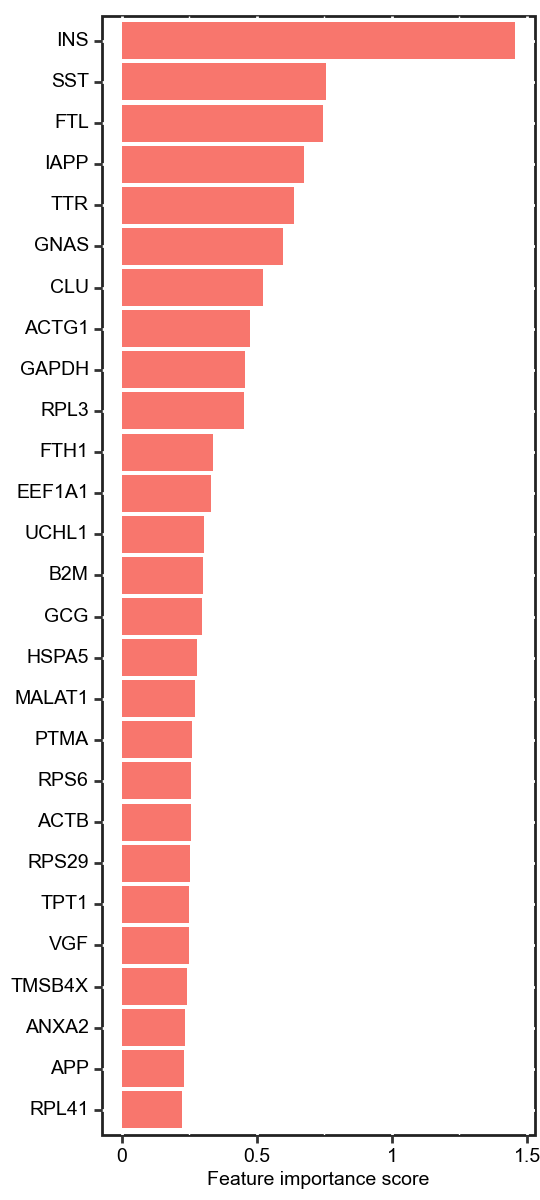

/home/wuyou/.conda/envs/sc/lib/python3.8/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 2.7 x 6 in image.
/home/wuyou/.conda/envs/sc/lib/python3.8/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: figure/barplot_gene_importance.pdf


In [9]:
#barplot feature importance

from plotnine import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
black = '#222222'
gray = '#666666'
red = '#FF3333'
green = '#66CC00'
blue = '#3333FF'
purple = '#9933FF'
orange = '#FF8000'
yellow = '#FFFF33'
c1="#F8766D"
c2="#00BA38" 
c3="#619CFF"
#colors = ['black', c1, 'black', 'black','black', 'black', c1, c1,'black', 'black','black', 'black','black', 'black', 'black', 'black']


data=pd.DataFrame({"Gene":top_50_gene,"Feature importance score":top_50_importance})
data['Gene'] = pd.Categorical(data['Gene'], categories=pd.unique(data['Gene'])[::-1])  #reorder legend
plt.figure(figsize=(12, 6))

p=(ggplot(data)+
  #coord_flip()+
  geom_bar(aes(x="Gene",y="Feature importance score"),fill=c1,stat="identity")
 + coord_flip()
#+theme_bw()
  +theme(panel_background=element_rect(fill=gray, alpha=0),
            #panel_grid_major=element_line(size=0.3, alpha=0.3,color=black),
            #panel_grid_minor=element_line(size=0.3, alpha=0.3,color=black),
            panel_border=element_rect(color=black, size=1),
            axis_text=element_text(size=7,family="Arial",color="black"),
            axis_title_x=element_text(size=7,family="Arial",color="black"),
            axis_title_y=element_text(size=7,family="Arial",color="black"),
            legend_position =  "none",figure_size=[2.7,6])
   #+labs(x="")
+labs(x = "")
  
  )


#ax = p.axes[0]
#labels = ax.get_yticklabels()

#for l, c in zip(labels, colors):
    #pass
    #l.set_color(c)

print(p)
#p.show()
p.save("figure/barplot_gene_importance.pdf")

In [10]:
#violinplot

import numpy as np
import scanpy as sc
import pandas as pd

sc.settings.verbosity = 3

sc.settings.set_figure_params(dpi=80, facecolor='white')

results_file = 'data/test.h5ad'  # the file that will store the analysis results

#read csv file
adata = sc.read_csv('data/baron/BaronMatrix.csv', delimiter=',', first_column_names=True)

#read annotation file
adata.obs = pd.read_csv('data/baron/BaronMetaData.csv', delimiter=',', index_col=0)

In [11]:
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)

normalizing counts per cell


    finished (0:00:00)


In [13]:
adata.obs['cell.type']

new_cell_type_names = {
    'Pancreatic stellate cells': 'Pancreatic stellate',
    'Peri-islet Schwann cells': 'Peri-islet Schwann',
    # Add more mappings as needed
}

adata.obs['cell.type'] = adata.obs['cell.type'].replace(new_cell_type_names)


/home/wuyou/.conda/envs/sc/lib/python3.8/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version. Use is_categorical_dtype instead.
... storing 'donor' as categorical
... storing 'cell.type' as categorical


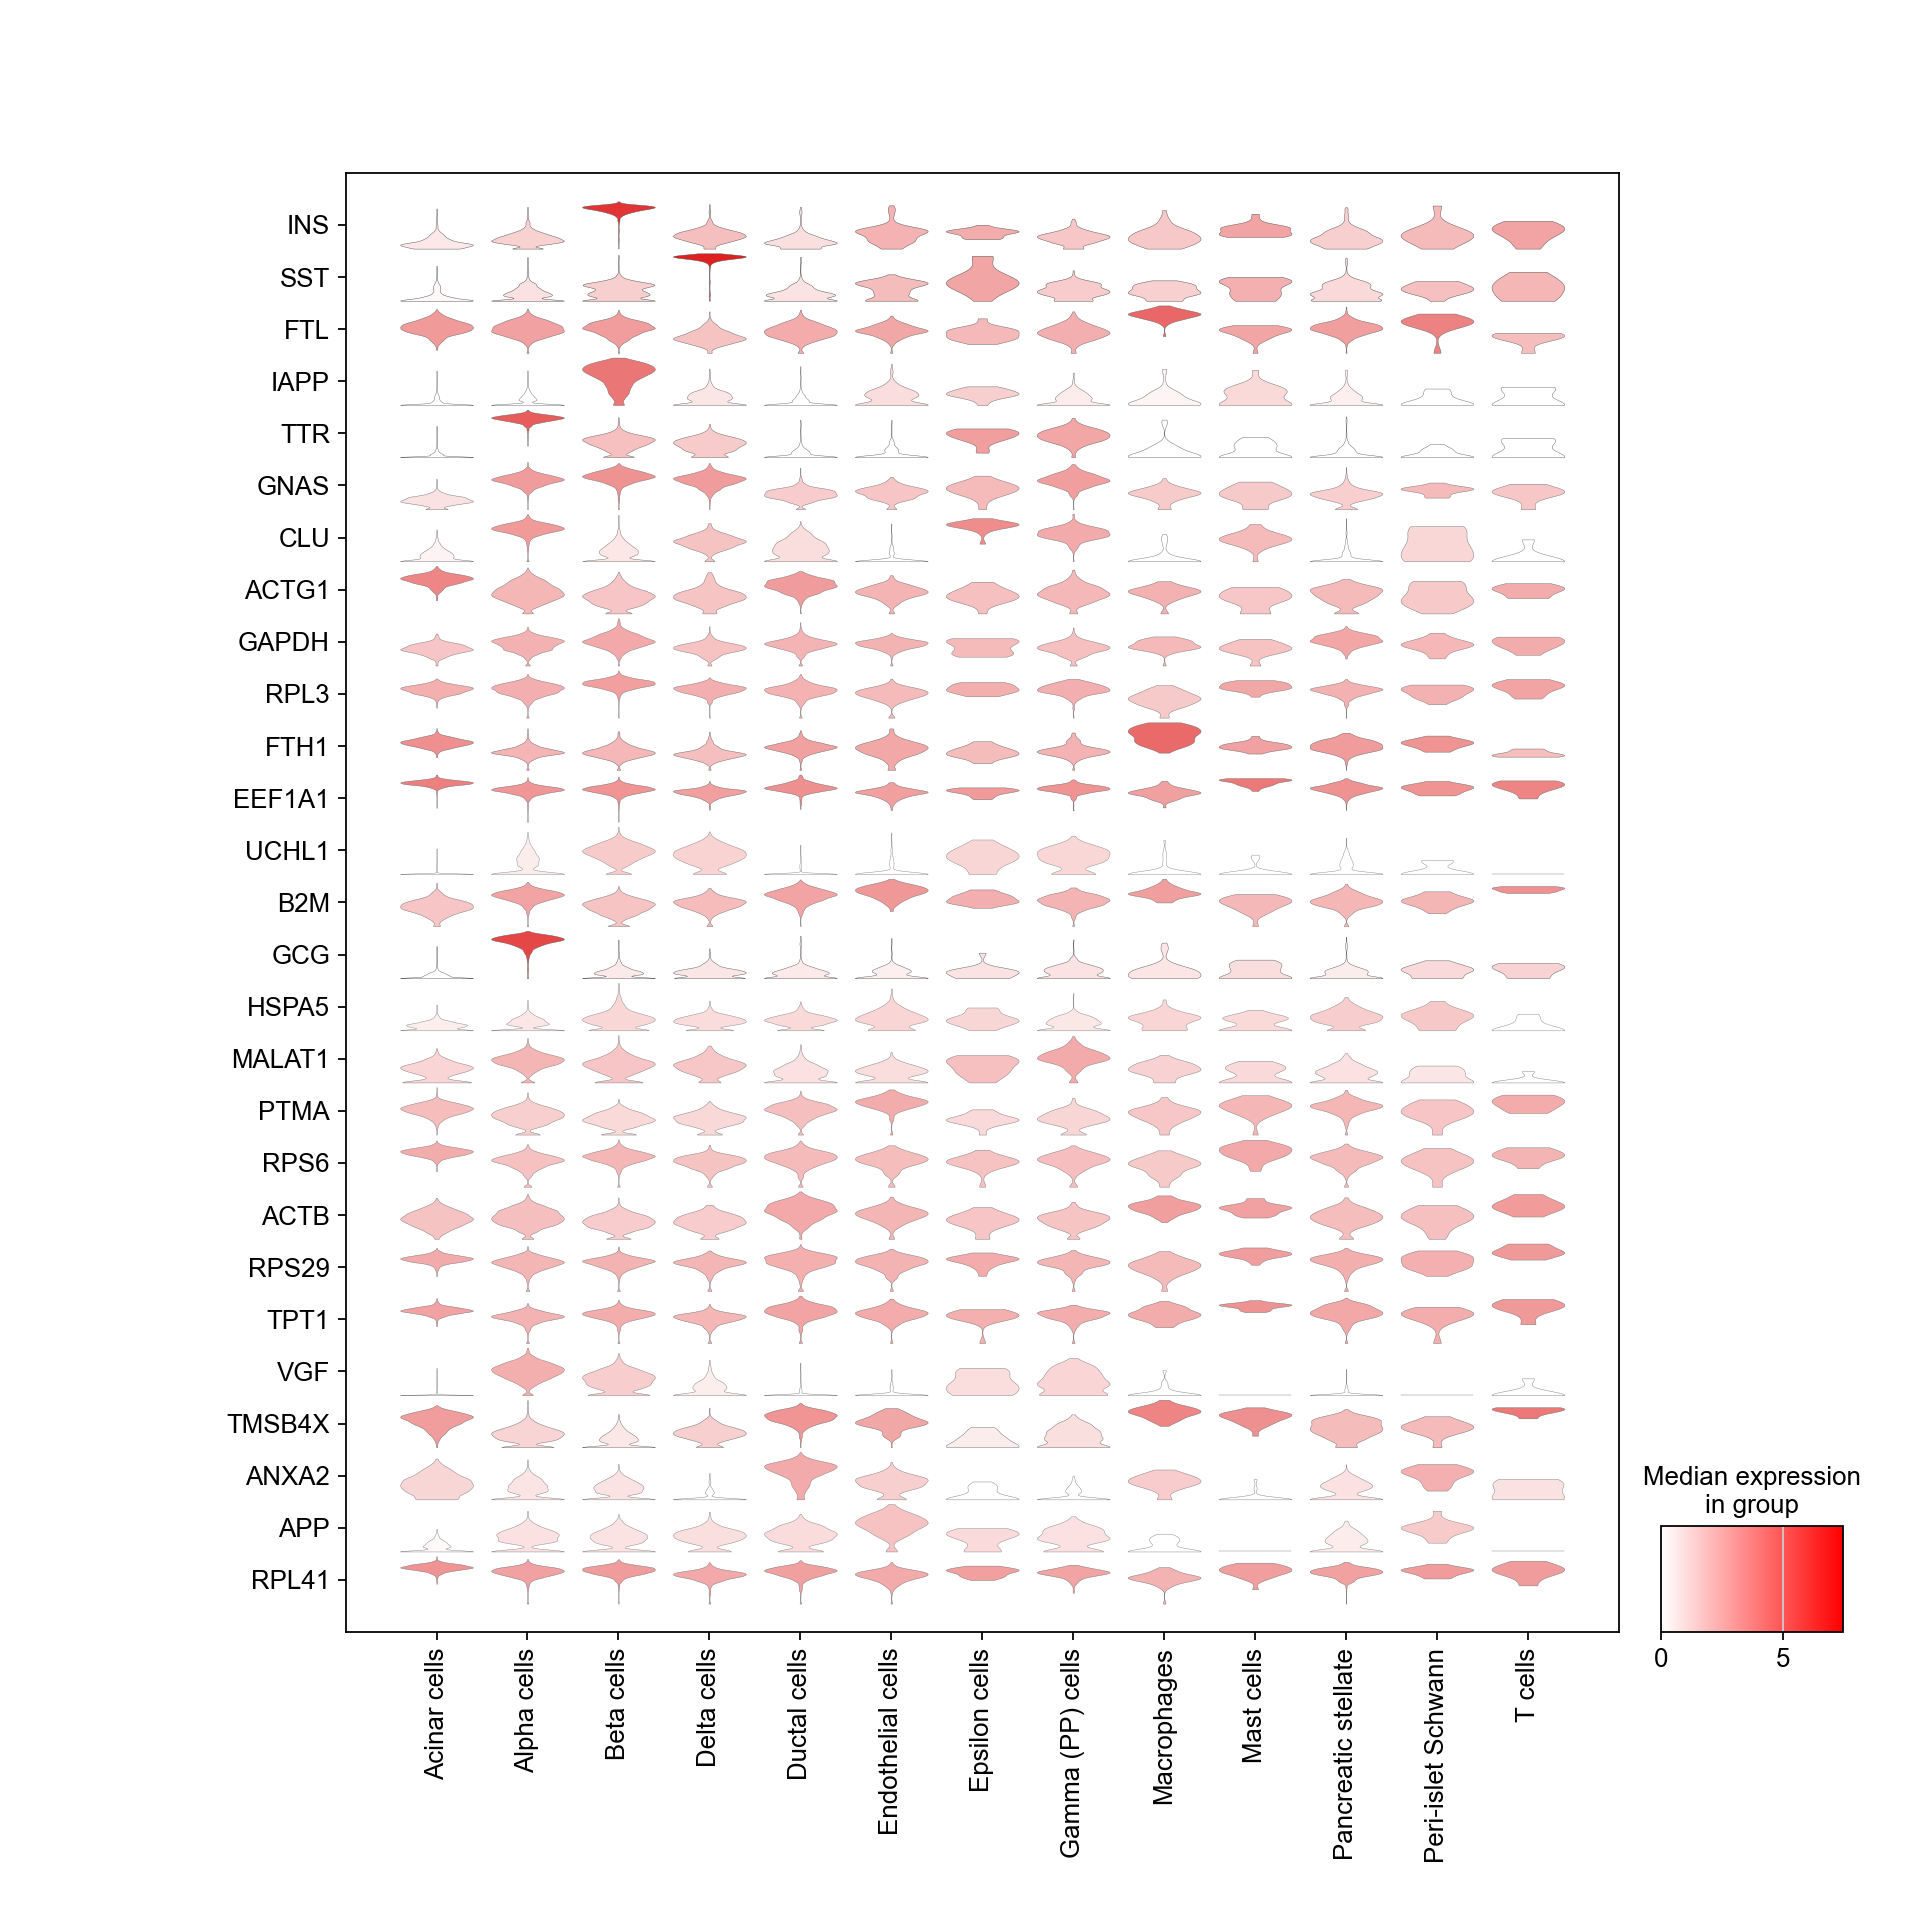

In [14]:
import matplotlib.colors as mcolors
# Define a custom colormap that transitions from white to red
cmap = mcolors.LinearSegmentedColormap.from_list('custom', ['#FFFFFF', "#FF0000"])



sc.pl.stacked_violin(adata, top_50_gene, groupby='cell.type',swap_axes=True,figsize=(12,12),cmap=cmap,save="baron_violinplot.pdf")





In [15]:
#gene marker

sc.pp.pca(adata, n_comps=50)
sc.pp.neighbors(adata)
sc.tl.umap(adata)

computing PCA
    with n_comps=50
    finished (0:00:12)
computing neighbors
    using 'X_pca' with n_pcs = 50


/home/wuyou/.conda/envs/sc/lib/python3.8/site-packages/umap/rp_tree.py:450: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "make_euclidean_tree" failed type inference due to: Cannot unify RandomProjectionTreeNode(array(int64, 1d, C), bool, none, none, none, none) and RandomProjectionTreeNode(none, bool, array(float32, 1d, C), float64, RandomProjectionTreeNode(array(int64, 1d, C), bool, none, none, none, none), RandomProjectionTreeNode(array(int64, 1d, C), bool, none, none, none, none)) for '$46call_function.15', defined at /home/wuyou/.conda/envs/sc/lib/python3.8/site-packages/umap/rp_tree.py (457)

File "../../.conda/envs/sc/lib/python3.8/site-packages/umap/rp_tree.py", line 457:
def make_euclidean_tree(data, indices, rng_state, leaf_size=30):
    <source elided>

        left_node = make_euclidean_tree(data, left_indices, rng_state, leaf_size)
        ^

[1] During: resolving callee type: recursive(type(CPUDispatcher(<function make

    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:08)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:21)


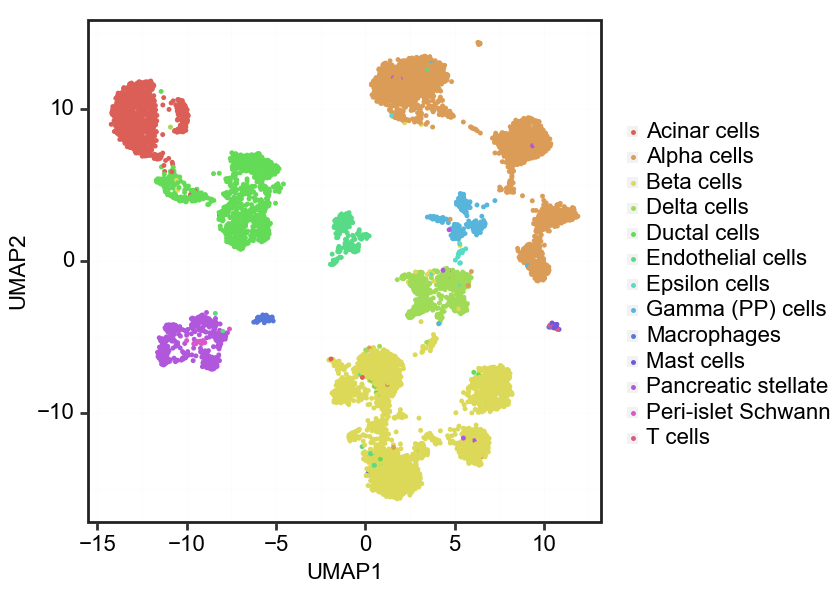

In [103]:
embedding = adata.obsm['X_umap']
embedding=pd.DataFrame(embedding,columns=["UMAP1","UMAP2"])
embedding


annotation=[celltype.replace("Pancreatic stellate cells","Pancreatic stellate").replace("Peri-islet Schwann cells","Peri-islet Schwann") for celltype in adata.obs["cell.type"].to_list()]
embedding["celltype"]=annotation

"""
0 Acinar cells 958
1 Beta cells 2525
2 Delta cells 601
3 Pancreatic stellate cells 457
4 Ductal cells 1077
5 Alpha cells 2326
6 Epsilon cells 18
7 Gamma (PP) cells 255
8 Endothelial cells 252
9 Macrophages 55
10 Peri-islet Schwann cells 13
11 Mast cells 25
12 T cells 7
"""

#zheng68k testset predict scatter

from scipy import interpolate
import traceback

from sklearn.decomposition import PCA
from sklearn import preprocessing
import matplotlib.pyplot as plt
from plotnine import *
import pandas as pd
import numpy as np

black = '#222222'
gray = '#666666'
red = '#FF3333'
green = '#66CC00'
blue = '#3333FF'
purple = '#9933FF'
orange = '#FF8000'
yellow = '#FFFF33'
c1="#F8766D"
c2="#00BA38" 
c3="#619CFF"



#data_A=data[data["label"]==0]
#data_m1A=data[data["label"]==1]
#data_m6A=data[data["label"]==2]

p = (ggplot()
    + geom_point(embedding,aes(x='UMAP1', y='UMAP2',color='factor(celltype)'), size=0.000001,alpha=1)
    +theme(
        figure_size=[4.2,3],
        axis_text=element_text(size=8,family="Arial",color="black"),
        axis_title_x=element_text(size=8,family="Arial",color="black"),
        axis_title_y=element_text(size=8,family="Arial",color="black"),
        plot_title=element_text(margin={'b': 1, 'r': 0, 'units': 'pt'},size=8,family="Arial",color="black",hjust=0.5),
        panel_background=element_rect(fill=gray, alpha=0),
        panel_grid_major=element_line(size=0.3, alpha=0.01,color=black),
        panel_grid_minor=element_line(size=0.3, alpha=0.01,color=black),
        panel_border=element_rect(color=black, size=1),
        legend_title = element_text(size=8,alpha=0,family="Arial",), #change legend title font size
        legend_text = element_text(size=8,family="Arial",),
        legend_background=element_rect(size=0.5,alpha=0),
        #legend_position=(1.2,0.95), 
        legend_key_size=4) #change legend text font size))
        +xlab("UMAP1")
        +ylab("UMAP2") 

)





#+scale_color_manual(values = ["#F8766D", "#00BA38","#619CFF"])+geom_density_2d(colour = "#F8766D",data=data_A)+geom_density_2d(colour = "#00BA38",data=data_m1A)+geom_density_2d(colour = "#619CFF",data=data_m6A)
#+ facet_wrap('G')
print(p)
#p.save('figure/zheng68k_TSNE_scatter_testdata_predicted.pdf')

In [49]:
embedding

,UMAP1,UMAP2,celltype,HADH
0,-10.134950,9.115817,Acinar cells,0.518391
1,-10.156344,8.687184,Acinar cells,0.166831
2,-10.615582,10.295269,Acinar cells,0.642461
3,-10.086872,9.332884,Acinar cells,0.000000
4,-10.222027,8.902925,Acinar cells,0.000000
...,...,...,...,...
8564,-11.142774,-5.588499,Pancreatic stellate cells,0.000000
8565,10.246407,3.005964,Alpha cells,0.000000
8566,5.969830,-9.995889,Beta cells,2.326289
8567,5.533805,-9.449854,Beta cells,2.088343


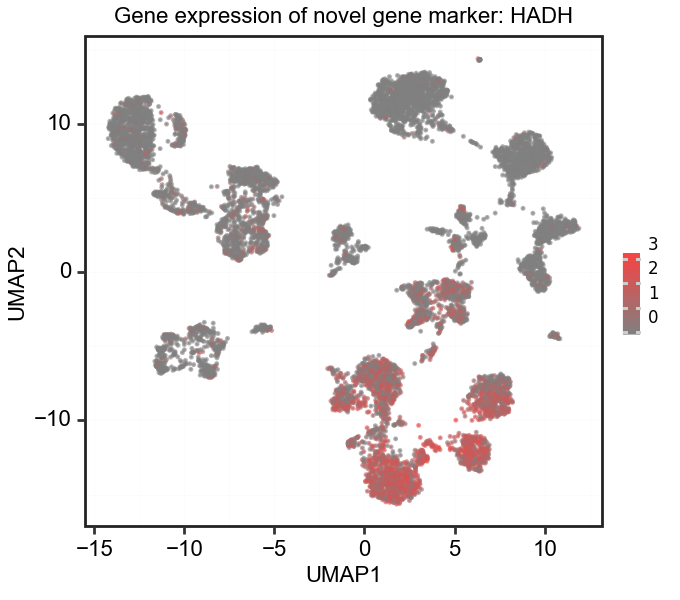

/home/wuyou/.conda/envs/sc/lib/python3.8/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 3.4 x 3 in image.
/home/wuyou/.conda/envs/sc/lib/python3.8/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: figure/Baron_novel_gene_marker_HADH.pdf


In [104]:
gene_expression=pd.DataFrame(adata.X,columns=adata.var_names.to_list())
gene_expression["HADH"]

embedding = adata.obsm['X_umap']
embedding=pd.DataFrame(embedding,columns=["UMAP1","UMAP2"])
embedding

embedding["celltype"]=adata.obs["cell.type"].to_list()
embedding["HADH"]=gene_expression["HADH"].to_list()
embedding["CDKN1C"]=gene_expression["CDKN1C"].to_list()
embedding["INS"]=gene_expression["INS"].to_list()
#embedding["HADH"][embedding["HADH"]>2.8]=2.8
#zheng68k testset predict scatter


import traceback

from sklearn.decomposition import PCA
from sklearn import preprocessing
import matplotlib.pyplot as plt
from plotnine import *
import pandas as pd
import numpy as np

black = '#222222'
gray = '#666666'
red = '#FF3333'
green = '#66CC00'
blue = '#3333FF'
purple = '#9933FF'
orange = '#FF8000'
yellow = '#FFFF33'
c1="#F8766D"
c2="#00BA38" 
c3="#619CFF"




#data_A=data[data["label"]==0]
#data_m1A=data[data["label"]==1]
#data_m6A=data[data["label"]==2]

p = (ggplot()
    + geom_point(embedding,aes(x='UMAP1', y='UMAP2',color='HADH'), size=0.0005,alpha=0.6)
    +theme(
        figure_size=[3.4,3],
        axis_text=element_text(size=8,family="Arial",color="black"),
        axis_title_x=element_text(size=8,family="Arial",color="black"),
        axis_title_y=element_text(size=8,family="Arial",color="black"),
        plot_title=element_text(margin={'b': 1, 'r': 0, 'units': 'pt'},size=8,family="Arial",color="black",hjust=0.5),
        panel_background=element_rect(fill=gray, alpha=0),
        panel_grid_major=element_line(size=0.3, alpha=0.01,color=black),
        panel_grid_minor=element_line(size=0.3, alpha=0.01,color=black),
        panel_border=element_rect(color=black, size=1),
        legend_title = element_text(size=6,alpha=0), #change legend title font size
        legend_text = element_text(size=6),
        legend_background=element_rect(size=0.5,alpha=0),
        #legend_position=(1.2,0.95), 
        legend_key_size=4) #change legend text font size))
        +xlab("UMAP1")
        +ylab("UMAP2") 
        +scale_color_gradient(low='grey', high="#F84444")
        +ggtitle("Gene expression of novel gene marker: HADH")
)





#+scale_color_manual(values = ["#F8766D", "#00BA38","#619CFF"])+geom_density_2d(colour = "#F8766D",data=data_A)+geom_density_2d(colour = "#00BA38",data=data_m1A)+geom_density_2d(colour = "#619CFF",data=data_m6A)
#+ facet_wrap('G')
print(p)
p.save('figure/Baron_novel_gene_marker_HADH.pdf')

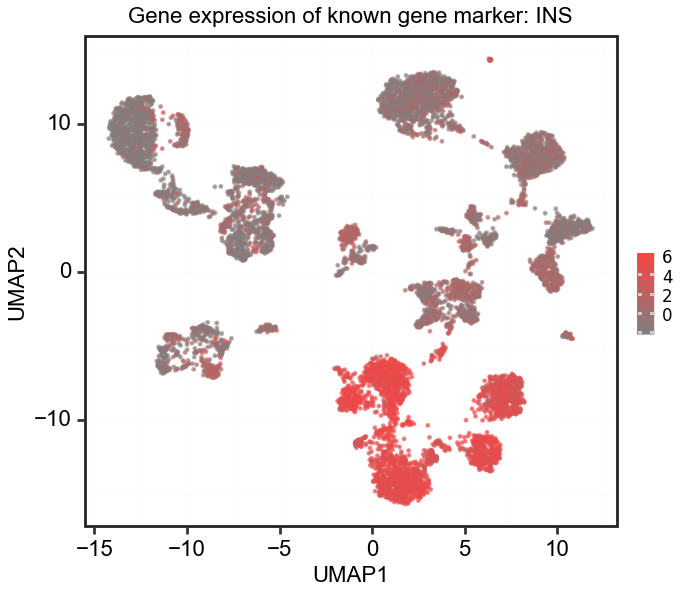

In [95]:
gene_expression=pd.DataFrame(adata.X,columns=adata.var_names.to_list())
gene_expression["HADH"]

embedding = adata.obsm['X_umap']
embedding=pd.DataFrame(embedding,columns=["UMAP1","UMAP2"])
embedding

embedding["celltype"]=adata.obs["cell.type"].to_list()
embedding["HADH"]=gene_expression["HADH"].to_list()
embedding["CDKN1C"]=gene_expression["CDKN1C"].to_list()
embedding["INS"]=gene_expression["INS"].to_list()
#embedding["HADH"][embedding["HADH"]>2.8]=2.8
#zheng68k testset predict scatter


import traceback

from sklearn.decomposition import PCA
from sklearn import preprocessing
import matplotlib.pyplot as plt
from plotnine import *
import pandas as pd
import numpy as np

black = '#222222'
gray = '#666666'
red = '#FF3333'
green = '#66CC00'
blue = '#3333FF'
purple = '#9933FF'
orange = '#FF8000'
yellow = '#FFFF33'
c1="#F8766D"
c2="#00BA38" 
c3="#619CFF"




#data_A=data[data["label"]==0]
#data_m1A=data[data["label"]==1]
#data_m6A=data[data["label"]==2]

p = (ggplot()
    + geom_point(embedding,aes(x='UMAP1', y='UMAP2',color='INS'), size=0.0005,alpha=0.6)
    +theme(
        figure_size=[3.4,3],
        axis_text=element_text(size=8,family="Arial",color="black"),
        axis_title_x=element_text(size=8,family="Arial",color="black"),
        axis_title_y=element_text(size=8,family="Arial",color="black"),
        panel_background=element_rect(fill=gray, alpha=0),
        plot_title=element_text(margin={'b': 1, 'r': 0, 'units': 'pt'},size=8,family="Arial",color="black",hjust=0.5),
        panel_grid_major=element_line(size=0.3, alpha=0.01,color=black),
        panel_grid_minor=element_line(size=0.3, alpha=0.01,color=black),
        panel_border=element_rect(color=black, size=1),
        legend_title = element_text(size=6,alpha=0), #change legend title font size
        legend_text = element_text(size=6),
        legend_background=element_rect(size=0.5,alpha=0),
        #legend_position=(1.2,0.95), 
        legend_key_size=4) #change legend text font size))
        +xlab("UMAP1")
        +ylab("UMAP2") 
        +scale_color_gradient(low='grey', high="#F84444")
        +ggtitle("Gene expression of known gene marker: INS")
)





#+scale_color_manual(values = ["#F8766D", "#00BA38","#619CFF"])+geom_density_2d(colour = "#F8766D",data=data_A)+geom_density_2d(colour = "#00BA38",data=data_m1A)+geom_density_2d(colour = "#619CFF",data=data_m6A)
#+ facet_wrap('G')
print(p)
#p.save('figure/zheng68k_TSNE_scatter_testdata_predicted.pdf')

In [119]:
#GO enrichment analysis

#contribution evaluation for all classes
weights=model.fc2.weight.detach().numpy().T        #transpose. The weights in torch is transposed by default.
weights_sum=[]

for i in range(len(weights)):
    weight_abs=[abs(weight) for weight in weights[i]]
    weight_sum=sum(weight_abs)
    weights_sum.append(weight_sum)


top_indices = np.argsort(weights_sum)[::-1][:20]    #top 10 indices 
top_indices
print(len(weights_sum))
print(len(GO_list))
for index in top_indices:
    print(GO_list[index],weights_sum[index])


1411
1411
GO:0006396 0.8457307908684015
GO:0000922 0.8455686289817095
GO:0030199 0.8395576202310622
GO:0043627 0.8298460398800671
GO:0030280 0.8200047183781862
GO:0031072 0.8062372575514019
GO:0030021 0.7973149735480547
GO:0099507 0.768874891102314
GO:0008150 0.7566315624862909
GO:0016567 0.7479354203678668
GO:0010506 0.7333888144930825
GO:0004467 0.7147597819566727
GO:0008277 0.7115719970315695
GO:0045111 0.7019971592817456
GO:0071805 0.691206764895469
GO:0009925 0.6874391270102933
GO:0007094 0.6832855828106403
GO:0016018 0.6777743664570153
GO:0031491 0.6746813608333468
GO:0006302 0.6701983399689198


<Figure size 1500x600 with 0 Axes>

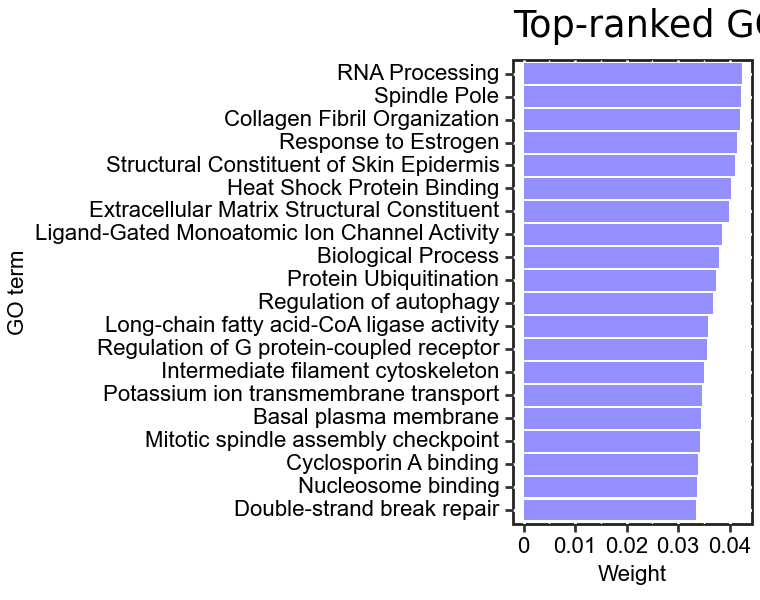

/home/wuyou/.conda/envs/sc/lib/python3.8/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 3.8 x 3 in image.
/home/wuyou/.conda/envs/sc/lib/python3.8/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: figure/Baron_GO_weight_all_classe.pdf


In [4]:
go_term = [
            "RNA Processing",
            "Spindle Pole",
            "Collagen Fibril Organization",
            "Response to Estrogen",
            "Structural Constituent of Skin Epidermis",
            "Heat Shock Protein Binding",
            "Extracellular Matrix Structural Constituent",
            "Ligand-Gated Monoatomic Ion Channel Activity",
            "Biological Process",
            "Protein Ubiquitination",
            "Regulation of autophagy",
            "Long-chain fatty acid-CoA ligase activity",
            "Regulation of G protein-coupled receptor",
            "Intermediate filament cytoskeleton",
            "Potassium ion transmembrane transport",
            "Basal plasma membrane",
            "Mitotic spindle assembly checkpoint",
            "Cyclosporin A binding",
            "Nucleosome binding",
            "Double-strand break repair"

            ]

weight=[0.8457307908684015,
        0.8455686289817095,
        0.8395576202310622,
        0.8298460398800671,
        0.8200047183781862,
        0.8062372575514019,
        0.7973149735480547,
        0.768874891102314,
        0.7566315624862909,
        0.7479354203678668,
        0.7333888144930825,
        0.7147597819566727,
        0.7115719970315695,
        0.7019971592817456,
        0.691206764895469,
        0.6874391270102933,
        0.6832855828106403,
        0.6777743664570153,
        0.6746813608333468,
        0.6701983399689198
        ]



from plotnine import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
black = '#222222'
gray = '#666666'
red = '#FF3333'
green = '#66CC00'
blue = '#3333FF'
purple = '#9933FF'
orange = '#FF8000'
yellow = '#FFFF33'
c1="#F8766D"
c2="#00BA38" 
c3="#619CFF"
#colors = ['black', c1, 'black', 'black','black', 'black', c1, c1,'black', 'black','black', 'black','black', 'black', 'black', 'black']

weight=np.array(weight)/len(weight)

data=pd.DataFrame({"GO term":go_term,"Weight":weight})
data['GO term'] = pd.Categorical(data['GO term'], categories=pd.unique(data['GO term'])[::-1])  #reorder legend
plt.figure(figsize=(15,6))

p=(ggplot(data)+
  #coord_flip()+
  geom_bar(aes(x="GO term",y="Weight"),fill="#9590FF",stat="identity")
 + coord_flip()
#+theme_bw()
  +theme(panel_background=element_rect(fill=gray, alpha=0),
            #panel_grid_major=element_line(size=0.3, alpha=0.3,color=black),
            #panel_grid_minor=element_line(size=0.3, alpha=0.3,color=black),
            panel_border=element_rect(color=black, size=1),
            axis_text=element_text(size=8,family="Arial",color="black"),
            axis_title_x=element_text(size=8,family="Arial",color="black"),
            axis_title_y=element_text(size=8,family="Arial",color="black"),
            legend_position =  "none",figure_size=[3.8,3])
   +labs(title="Top-ranked GO terms that contributed to all the cell types")
#+labs(y = "-log10(pvalue)")

  )


#ax = p.axes[0]
#labels = ax.get_yticklabels()

#for l, c in zip(labels, colors):
    #pass
    #l.set_color(c)

print(p)
#p.show()
p.save("figure/Baron_GO_weight_all_classe.pdf")

In [150]:
#gene contribution evaluation for single class 


weights=model.fc2.weight.detach().numpy().T        #transpose. The weights in torch is transposed by default.
weights_sum=[]
print(classes)
class_index=1
print(classes[class_index])
for i in range(len(weights)):
    weight_abs=abs(weights[i][class_index])

    weights_sum.append(weight_abs)


top_indices = np.argsort(weights_sum)[::-1][:20]    #top 10 indices 
top_indices

for index in top_indices:
    print(GO_list[index],weights_sum[index])




#go to heatmap

['Acinar cells', 'Beta cells', 'Delta cells', 'Pancreatic stellate cells', 'Ductal cells', 'Alpha cells', 'Epsilon cells', 'Gamma (PP) cells', 'Endothelial cells', 'Macrophages', 'Peri-islet Schwann cells', 'Mast cells', 'T cells']
Beta cells
GO:0046854 0.13504611
GO:0071347 0.12069841
GO:0030527 0.11016411
GO:0050804 0.11013879
GO:0001947 0.10884197
GO:0016529 0.10590158
GO:0006836 0.10354289
GO:0007275 0.10197882
GO:0032147 0.10043505
GO:0006284 0.094362795
GO:0031424 0.09402915
GO:0140677 0.09238849
GO:0098839 0.08962255
GO:0008519 0.08672418
GO:0001533 0.08589503
GO:0019894 0.08522762
GO:0000045 0.083968475
GO:0043687 0.08299301
GO:0007015 0.07939852
GO:0007595 0.07798949


<Figure size 1200x480 with 0 Axes>

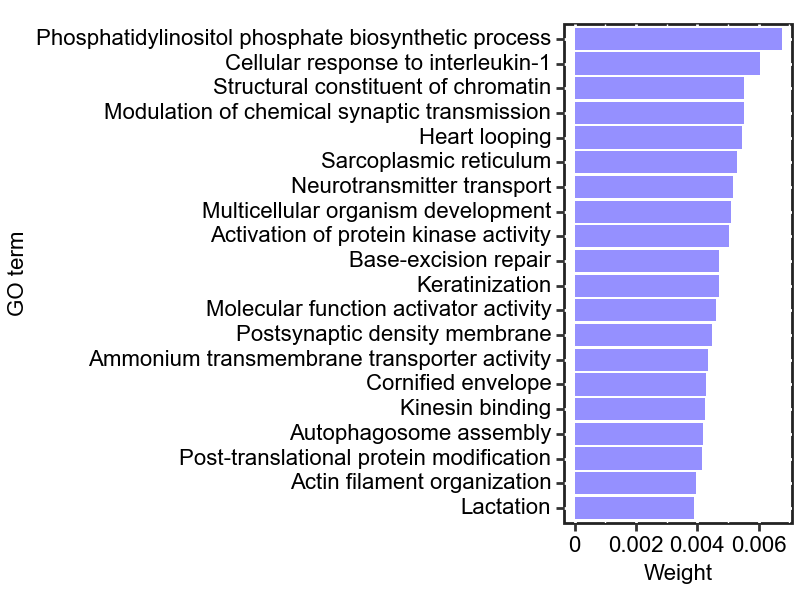

/home/wuyou/.conda/envs/sc/lib/python3.8/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 4 x 3 in image.
/home/wuyou/.conda/envs/sc/lib/python3.8/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: figure/Baron_GO_weight_beta_cell.pdf


In [24]:
go_term = [
            "Phosphatidylinositol phosphate biosynthetic process",
            "Cellular response to interleukin-1",
            "Structural constituent of chromatin",
            "Modulation of chemical synaptic transmission",
            "Heart looping",
            "Sarcoplasmic reticulum",
            "Neurotransmitter transport",
            "Multicellular organism development",
            "Activation of protein kinase activity",
            "Base-excision repair",
            "Keratinization",
            "Molecular function activator activity",
            "Postsynaptic density membrane",
            "Ammonium transmembrane transporter activity",
            "Cornified envelope",
            "Kinesin binding",
            "Autophagosome assembly",
            "Post-translational protein modification",
            "Actin filament organization",
            "Lactation"

            ]

weight=[0.13504611,
        0.12069841,
        0.11016411,
        0.11013879,
        0.10884197,
        0.10590158,
        0.10354289,
        0.10197882,
        0.10043505,
        0.094362795,
        0.09402915,
        0.09238849,
        0.08962255,
        0.08672418,
        0.08589503,
        0.08522762,
        0.083968475,
        0.08299301,
        0.07939852,
        0.07798949
        ]

weight=np.array(weight)/len(weight)

from plotnine import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
black = '#222222'
gray = '#666666'
red = '#FF3333'
green = '#66CC00'
blue = '#3333FF'
purple = '#9933FF'
orange = '#FF8000'
yellow = '#FFFF33'
c1="#F8766D"
c2="#00BA38" 
c3="#619CFF"
#colors = ['black', c1, 'black', 'black','black', 'black', c1, c1,'black', 'black','black', 'black','black', 'black', 'black', 'black']


data=pd.DataFrame({"GO term":go_term,"Weight":weight})
data['GO term'] = pd.Categorical(data['GO term'], categories=pd.unique(data['GO term'])[::-1])  #reorder legend
plt.figure(figsize=(15,6))

p=(ggplot(data)+
  #coord_flip()+
  geom_bar(aes(x="GO term",y="Weight"),fill="#9590FF",stat="identity")
 + coord_flip()
#+theme_bw()
  +theme(panel_background=element_rect(fill=gray, alpha=0),
            #panel_grid_major=element_line(size=0.3, alpha=0.3,color=black),
            #panel_grid_minor=element_line(size=0.3, alpha=0.3,color=black),
            panel_border=element_rect(color=black, size=1),
            axis_text=element_text(size=8,family="Arial",color="black"),
            axis_title_x=element_text(size=8,family="Arial",color="black"),
            axis_title_y=element_text(size=8,family="Arial",color="black"),
            legend_position =  "none",figure_size=[4,3])
   #+labs(x="")
#+labs(y = "-log10(pvalue)")
  
  )


#ax = p.axes[0]
#labels = ax.get_yticklabels()

#for l, c in zip(labels, colors):
    #pass
    #l.set_color(c)

print(p)
#p.show()
p.save("figure/Baron_GO_weight_beta_cell.pdf")